In [2]:
#imports
#numpy,pandas,scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt

In [3]:
#estimators
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

In [5]:
#data
rawData = pd.read_csv('default of credit card clients.csv', header=1)
rawData.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
#Renaming dependant attributes for simplicity
rawData = rawData.rename(columns = {'default payment next month': 'Default'})

In [7]:
#initial feature selection: removing ID
features = rawData.iloc[:,1:24]
print(features.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


In [8]:
#dependent variable
depVar = rawData['Default']

In [9]:
#Preprocessing = scaling + splitting
X_train, X_test, y_train, y_test = train_test_split(features, depVar, test_size = 0.3, random_state=123)
print(X_train.shape, X_test.shape)

(21000, 23) (9000, 23)


In [11]:
cv = StratifiedKFold(5,random_state=123)

# Principal Component analysis

In [54]:
pca = PCA(0.98).fit(X_train)

In [55]:
print('explained variance by each component: %s' 
      %pca.explained_variance_ratio_)

explained variance by each component: [0.60441451 0.29675411 0.03124743 0.0188716  0.01038141 0.00957023
 0.00747101 0.00650953]


In [56]:
pca.explained_variance_ratio_.sum()

0.9852198200835673

In [57]:
print('%0.3f of variance are explained by %s components' % (pca.explained_variance_ratio_.sum(),len(pca.explained_variance_ratio_)))

0.985 of variance are explained by 8 components


In [62]:
X_train_pca = pd.DataFrame(pca.transform(X_train),index = X_train.index)
X_test_pca = pca.transform(X_test)


# Out of the box : Classifiers - with vs. without preprocessing

In [196]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
5576,150000,1,2,2,26,-2,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
25512,30000,2,2,2,25,0,0,0,0,0,...,21034,22050,22490,22961,1325,1350,1366,806,834,836
1326,170000,1,2,1,48,0,0,0,0,0,...,136331,123913,122657,122225,5396,5000,5000,5000,5000,4000
17003,30000,2,1,2,22,0,0,0,0,0,...,30582,28983,27947,26630,1800,3000,1404,559,533,1000
29325,50000,1,2,2,27,0,0,0,0,0,...,49252,28838,2102,19366,3000,4063,1700,600,20000,1000


In [66]:
classifiers = [
    KNeighborsClassifier(),
    SVC(random_state=123, gamma = 'auto'),
    DecisionTreeClassifier(max_depth = 10, random_state=123),
    RandomForestClassifier(n_estimators = 100, max_features = 10, random_state=123)
]


In [67]:
models_ootb = pd.DataFrame(np.zeros((4,4)), columns = ['KNN','SVM','DecisionTree','RandomForest'], 
                      index = ['TrainSet: mean CV','TestSet','TrainSet: mean CV w PP','TestSet wPP'])

In [68]:
c = 0
for clf in classifiers:
    pipe = Pipeline(steps = [('PP',StandardScaler()),('classifier',clf)]) # define the pipeline object.
    clf.fit(X_train,y_train)
    models_ootb.iloc[0,c] = cross_val_score(clf,X_train,y_train,cv = StratifiedKFold(5,random_state=123)).mean()
    models_ootb.iloc[1,c] = clf.score(X_test,y_test)
    #print('mean cv model score over training set : %.3f' %cross_val_score(clf,X_train,y_train,cv = StratifiedKFold(5,random_state=123)).mean())
    #print('model score over testing set : %.3f' %clf.score(X_test,y_test))
    pipe.fit(X_train,y_train)
    models_ootb.iloc[2,c] = cross_val_score(pipe,X_train,y_train,cv = StratifiedKFold(5,random_state=123)).mean()
    models_ootb.iloc[3,c] = pipe.score(X_test,y_test)
    c=c+1

In [69]:
models_ootb

,KNN,SVM,DecisionTree,RandomForest
TrainSet: mean CV,0.748714,0.777000,0.807572,0.814762
TestSet,0.755000,0.784667,0.811222,0.815889
TrainSet: mean CV w PP,0.793762,0.818286,0.807667,0.814905
TestSet wPP,0.788778,0.820000,0.811000,0.815889


- Scaling and centering improves accuracy for both KNN and SVM. As can be expected - non-parametric methods are not affected

# Decision Tree Model - Feature importance & Tuning

In [103]:
models_tuned = pd.DataFrame(np.zeros((2,4)), columns = ['KNN','SVM','DecisionTree','RandomForest'], 
                      index = ['TrainSet','TestSet'])

model score over training set : 0.850
model score (mean over cross validation) over training set : 0.808


Text(0.5, 1.0, 'Feature importance - Decision Tree')

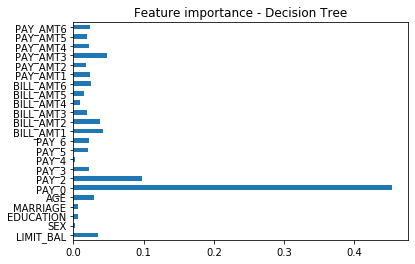

In [186]:
modelDT = DecisionTreeClassifier(max_depth = 10,random_state=123)
modelDT.fit(X_train,y_train)
print('model score over training set : %.3f' %modelDT.score(X_train,y_train))
print('model score (mean over cross validation) over training set : %.3f' %cross_val_score(modelDT,X_train,y_train,cv = StratifiedKFold(5,random_state=123)).mean())
feat_importances = pd.Series(modelDT.feature_importances_, index = features.columns)
feat_importances.plot(kind='barh');
plt.title('Feature importance - Decision Tree')

In [165]:
feat_importances.nlargest(2).index

Index(['PAY_0', 'PAY_2'], dtype='object')

In [166]:
reduced_X_train = X_train[feat_importances.nlargest(2).index]

In [167]:
reduced_X_test = X_test[feat_importances.nlargest(2).index]

In [168]:

modelDT = DecisionTreeClassifier(max_depth=10,random_state=123)
modelDT.fit(reduced_X_train,y_train)
print('model score over training set : %.3f' %modelDT.score(reduced_X_train,y_train))
print('model score (mean over cross validation) over training set : %.3f' %cross_val_score(modelDT,reduced_X_train,y_train,cv = StratifiedKFold(5,random_state=123)).mean())

model score over training set : 0.820
model score (mean over cross validation) over training set : 0.819


- Minimal change when reducing to 7 attributes

In [169]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [170]:
cv = StratifiedKFold(5,random_state=123)
modelDT = GridSearchCV(DecisionTreeClassifier(random_state = 123), param_grid = {'criterion':['gini','entropy'],'max_depth':[5,10,15,20]},cv=cv,verbose = 1, refit = True, scoring = 'accuracy')

In [171]:
modelDT.fit(reduced_X_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=123,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
      

In [172]:
modelDT.best_score_, modelDT.best_params_

(0.8192380952380952, {'criterion': 'gini', 'max_depth': 5})

In [173]:
modelDT = DecisionTreeClassifier(random_state = 123, criterion = 'entropy', max_depth = 5)
modelDT.fit(reduced_X_train,y_train)
print(modelDT.score(reduced_X_train,y_train))
print(modelDT.score(reduced_X_test,y_test))

0.8199047619047619
0.8221111111111111


In [174]:
models_tuned['DecisionTree'] = [modelDT.score(reduced_X_train,y_train),modelDT.score(reduced_X_test,y_test)]
models_tuned

,KNN,SVM,DecisionTree,RandomForest
TrainSet,0.0,0.0,0.819905,0.0
TestSet,0.0,0.0,0.822111,0.0


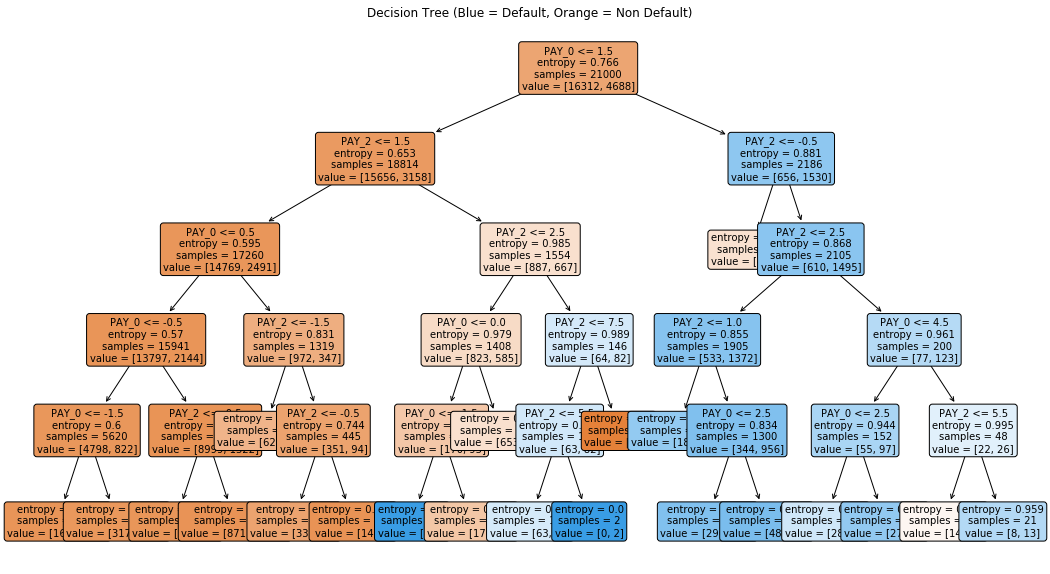

In [175]:
plt.figure(figsize = [18,10])
from sklearn import tree
tree.plot_tree(modelDT, filled = True, fontsize = 10, feature_names = feat_importances.nlargest(7).index, rounded = True)
plt.title('Decision Tree (Blue = Default, Orange = Non Default)')
#plt.legend(['Blue = Default', 'Orange = Non Default'])
plt.show()

#  K-NN Tuning (with scaled features) + PCA

In [177]:
KNeighborsClassifier().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [178]:
parameters = {'classifier__n_neighbors':[1,5,10, 25, 50]}
cv = StratifiedKFold(5,random_state=123)

In [179]:
grid = GridSearchCV(Pipeline([('PP',StandardScaler()),('classifier',KNeighborsClassifier())]), param_grid=parameters, cv=cv, verbose = 1,refit=True, scoring = 'accuracy')
grid_pca = GridSearchCV(Pipeline([('PP',StandardScaler()),('PCA',PCA(n_components= 0.98)),('classifier',KNeighborsClassifier())]), param_grid=parameters, cv=cv, verbose = 1,refit=True, scoring = 'accuracy')

In [180]:
grid.fit(X_train, y_train) #scale + knn
grid_pca.fit(X_train, y_train) #scale+pca+knn


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   55.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   22.5s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('PP',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('PCA',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.98,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('classifier',
                                        KNeighborsClassifier(algorithm='auto',
                                                            

In [181]:
print(grid.best_score_,grid.best_params_)
print(grid_pca.best_score_,grid_pca.best_params_)

0.8093333333333333 {'classifier__n_neighbors': 25}
0.8101428571428572 {'classifier__n_neighbors': 25}


- PCA improves the score

In [182]:
knn = Pipeline(steps = [('pca',PCA(n_components= 0.98)),('clf',KNeighborsClassifier(n_neighbors = 25))])
#knn = KNeighborsClassifier(n_neighbors = 25)
#Pipeline(steps = [('PP',StandardScaler()),('classifier',clf)])

In [183]:
knn.fit(X_train,y_train)
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))

0.785047619047619
0.7841111111111111


In [184]:
models_tuned['KNN'] = [knn.score(X_train,y_train),knn.score(X_test,y_test)]
models_tuned

,KNN,SVM,DecisionTree,RandomForest
TrainSet,0.785048,0.0,0.819905,0.0
TestSet,0.784111,0.0,0.822111,0.0


# SVM Tuning (with scaled features) 

In [96]:
svm = GridSearchCV(Pipeline([('PP',StandardScaler()),('SVM',SVC( random_state = 123))])
                   ,param_grid = {'SVM__kernel' : ['rbf','poly'], 'SVM__C':[0.001,0.01,0.1,1,10,100]}, cv= cv,refit = True, verbose = 1, scoring = 'accuracy', n_jobs =-1)
svm.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('PP',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('SVM',
                                        SVC(C=1.0, cache_size=200,
                                            class_weight=None, coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='auto_deprecated',
                                            kernel='rbf', max_iter=-1,
                                            probability=False, random_state=123,
                                            shrinking=True, tol=0.001,
           

In [97]:
svm.cv_results_

{'mean_fit_time': array([ 23.05327654,  26.5466085 ,  27.01012964,  27.78280025,
         29.00749645,  30.74989843,  34.35525341,  42.1259531 ,
         47.43459935, 135.85114741, 127.45685711, 455.53963122]),
 'std_fit_time': array([ 0.77921468,  1.07330949,  0.46598669,  0.62550385,  0.90867282,
         0.88964776,  0.66637492,  3.25347426,  1.33785107,  8.79801559,
         3.27137062, 46.13074798]),
 'mean_score_time': array([2.61764035, 2.03741107, 2.69580145, 2.23029857, 2.43132944,
        2.27861524, 2.56141396, 1.85679545, 2.31583381, 1.49263282,
        1.93576474, 0.7180078 ]),
 'std_score_time': array([0.11105309, 0.14193234, 0.29701036, 0.18976356, 0.41434002,
        0.18169468, 0.09773987, 0.16081192, 0.24462745, 0.13751581,
        0.2603471 , 0.12373143]),
 'param_SVM__C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10, 100,
                    100],
              mask=[False, False, False, False, False, False, False, False,
                    F

In [98]:
svm.best_score_, svm.best_params_

(0.8182857142857143, {'SVM__C': 1, 'SVM__kernel': 'rbf'})

In [99]:
svm = Pipeline([('PP',StandardScaler()),('SVM',SVC( random_state = 123, C = 1, kernel = 'rbf'))])

In [100]:
svm.fit(X_train,y_train)
print(svm.score(X_train,y_train))
print(svm.score(X_test,y_test))

0.8248571428571428
0.82


In [101]:
models_tuned['SVM'] = [svm.score(X_train,y_train),svm.score(X_test,y_test)]
models_tuned

,KNN,SVM,DecisionTree,RandomForest
TrainSet,0.785048,0.824857,0.821238,0.0
TestSet,0.784111,0.820000,0.817667,0.0


# Random Forest tuning + RFE

In [12]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import GradientBoostingClassifier
rf = RandomForestClassifier(n_estimators = 100,random_state = 123)
rfe = RFECV(estimator=rf,cv=cv, scoring = 'accuracy', step=1,verbose = 0, n_jobs = -1)
rfe.fit(X_train, y_train)

print("Optimal number of features : %d" % rfe.n_features_)

Optimal number of features : 21


In [20]:
X_train.columns[rfe.support_]

Index(['LIMIT_BAL', 'EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4',
       'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

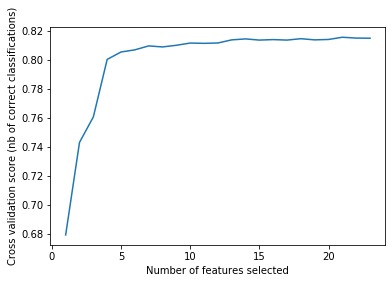

In [21]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [23]:
rfe.grid_scores_[20]

0.8153814768302856

In [24]:
X_train_rf = X_train[X_train.columns[rfe.support_]]
X_test_rf = X_test[X_train.columns[rfe.support_]]
X_train_rf.shape

(21000, 21)

In [25]:
rfmodel = GridSearchCV(RandomForestClassifier(random_state = 123),
                   param_grid = {'n_estimators' : [100,200,300], 'max_depth':[5,10,25]}, cv= cv,refit = True, verbose = 1, scoring = 'accuracy', n_jobs =-1)
rfmodel.fit(X_train_rf,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   35.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=False),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=123,
                                              verbose=0, warm_start

In [26]:
rfmodel.best_score_, rfmodel.best_params_

(0.8192380952380952, {'max_depth': 10, 'n_estimators': 100})

In [27]:
rfmodel.cv_results_

{'mean_fit_time': array([ 1.82594872,  3.68646674,  5.56727552,  3.4066329 ,  6.95741463,
        10.78528972,  6.21726637, 11.480023  , 14.19254122]),
 'std_fit_time': array([0.01593115, 0.02687601, 0.05709816, 0.0641282 , 0.01159874,
        0.14206074, 0.23159292, 0.56569247, 0.19082057]),
 'mean_score_time': array([0.05623469, 0.10309892, 0.14371586, 0.06873446, 0.14352183,
        0.21213555, 0.11908131, 0.19691548, 0.22585921]),
 'std_score_time': array([0.0076515 , 0.00765224, 0.01821695, 0.00765216, 0.00635281,
        0.00572383, 0.00149225, 0.02329028, 0.0088916 ]),
 'param_max_depth': masked_array(data=[5, 5, 5, 10, 10, 10, 25, 25, 25],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 300, 100, 200, 300, 100, 200, 300],
              mask=[False, False, False, False, False, False, False, False,
                    Fals

In [28]:
rfmodel = RandomForestClassifier(max_depth = 10, n_estimators = 100, random_state = 123)

In [29]:
rfmodel.fit(X_train_rf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [30]:
rfmodel.score(X_test_rf,y_test)

0.8207777777777778

In [116]:
models_tuned['RandomForest'] = [rfmodel.score(X_train_rf,y_train),rfmodel.score(X_test_rf,y_test)]


# Tuned Models results

In [117]:
models_tuned

,KNN,SVM,DecisionTree,RandomForest
TrainSet,0.785048,0.824857,0.821238,0.859667
TestSet,0.784111,0.820000,0.817667,0.820778


- Best model is Random Forest

In [31]:
predictions = rfmodel.predict(X_test_rf)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[6670,  382],
       [1231,  717]], dtype=int64)

In [43]:
mu, sigma = 0, 0.1 # mean and standard deviation
s1 = np.random.normal(mu, sigma, len(y_test))
s2 = np.random.normal(mu, sigma, len(y_test))

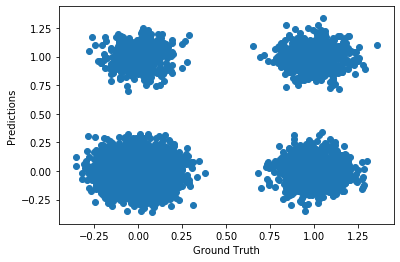

In [45]:
plt.scatter(y_test+s1, predictions+s2)
plt.xlabel('Ground Truth')
plt.ylabel('Predictions')
plt.show();

## Binning attributes - Age, Limit_balance

In [118]:
rawData['Binned_Age'] = pd.cut(rawData.AGE, bins =[20,25,30,35,40,50,60,80], 
                              labels = ['20-24','25-29','30-34','35-39','40-49','50-59','60-79'], include_lowest = True)
rawData['Binned_Limit_Bal'] = pd.cut(rawData.LIMIT_BAL, bins = [10000,100000,200000,300000,500000,1000000],
                                    labels = ['<100k','100k-200k','200k-300k','300k-500k','>500k'],include_lowest = True)


In [335]:
rawData[['Binned_Age','Binned_Limit_Bal']]

,Binned_Age,Binned_Limit_Bal
0,20-24,<100k
1,25-29,100k-200k
2,30-34,<100k
3,35-39,<100k
4,50-59,<100k
...,...,...
29995,35-39,200k-300k
29996,40-49,100k-200k
29997,35-39,<100k
29998,40-49,<100k


In [34]:
CatDummies = pd.get_dummies(rawData[['Binned_Age','Binned_Limit_Bal']])
CatDummies.head()

,Binned_Age_20-24,Binned_Age_25-29,Binned_Age_30-34,Binned_Age_35-39,Binned_Age_40-49,Binned_Age_50-59,Binned_Age_60-79,Binned_Limit_Bal_<100k,Binned_Limit_Bal_100k-200k,Binned_Limit_Bal_200k-300k,Binned_Limit_Bal_300k-500k,Binned_Limit_Bal_>500k
0,1,0,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,1,0,0,0,0


In [50]:
features_dummied = pd.concat([features,CatDummies], axis = 1)
features_dummied.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'Binned_Age_20-24', 'Binned_Age_25-29', 'Binned_Age_30-34',
       'Binned_Age_35-39', 'Binned_Age_40-49', 'Binned_Age_50-59',
       'Binned_Age_60-79', 'Binned_Limit_Bal_<100k',
       'Binned_Limit_Bal_100k-200k', 'Binned_Limit_Bal_200k-300k',
       'Binned_Limit_Bal_300k-500k', 'Binned_Limit_Bal_>500k'],
      dtype='object')

In [51]:
features_dummied.drop(['LIMIT_BAL','AGE'], axis = 1, inplace = True)


In [53]:
print(features_dummied.head())

   SEX  EDUCATION  MARRIAGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  \
0    2          2         1      2      2     -1     -1     -2     -2   
1    2          2         2     -1      2      0      0      0      2   
2    2          2         2      0      0      0      0      0      0   
3    2          2         1      0      0      0      0      0      0   
4    1          2         1     -1      0     -1      0      0      0   

   BILL_AMT1  ...  Binned_Age_30-34  Binned_Age_35-39  Binned_Age_40-49  \
0       3913  ...                 0                 0                 0   
1       2682  ...                 0                 0                 0   
2      29239  ...                 1                 0                 0   
3      46990  ...                 0                 1                 0   
4       8617  ...                 0                 0                 0   

   Binned_Age_50-59  Binned_Age_60-79  Binned_Limit_Bal_<100k  \
0                 0                 0        

In [119]:
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    features_dummied, depVar, test_size = 0.3, random_state=123)

rf_d = Pipeline([('clf',RandomForestClassifier(max_depth = 10, n_estimators = 100,random_state=123))])

rf_d.fit(X_train_d, y_train_d)
print("RF train accuracy: %0.3f" % rf_d.score(X_train_d, y_train_d))
print("RF test accuracy: %0.3f" % rf_d.score(X_test_d, y_test_d))

In [122]:
svm_d = Pipeline([('PP',StandardScaler()),('SVM',SVC( random_state = 123, C = 1, kernel = 'rbf'))])

svm_d.fit(X_train_d, y_train_d)
print("SVM train accuracy: %0.3f" % svm_d.score(X_train_d, y_train_d))
print("SVM test accuracy: %0.3f" % svm_d.score(X_test_d, y_test_d))

SVM train accuracy: 0.825
SVM test accuracy: 0.820


- Not a significant change from previous results